## Generate tables and figures for the paper

In [2]:
import os
import pandas as pd
import json


output_dir = "../output"
assert os.path.exists(output_dir)


def read_results(results_path: os.PathLike) -> pd.DataFrame:
    """
    Read the results from the results path.

    Example of results path:
    ```
    output/randomized_greedy/instances_generic/20250722_115309/
    ```
    """
    # list all subdirectories in results_path, which are the instances
    instances = os.listdir(results_path)
    # for every file in an instance, read it and concatenate them
    df = pd.DataFrame()
    for instance in instances:
        configurations = os.listdir(os.path.join(results_path, instance))
        for configuration in configurations:
            file = os.path.join(results_path, instance, configuration)
            # read lines of file, which can be json-decoded, use readlines
            with open(file, "r") as f:
                lines = f.readlines()
                for line in lines:
                    json_line = json.loads(line)
                    # append to dataframe
                    df = pd.concat([df, pd.DataFrame([json_line])])

    # add extra data:
    df["dataset"] = results_path.split("/")[-2]
    df["subdataset"] = df.apply(
        lambda row: row["dataset"] if "release" in row["dataset"] else row["instance_name"].split("_")[0], axis=1
    )
    df["method"] = results_path.split("/")[-3]

    return df

rename_dataset = {
    "instances_generic": "RG",
    "instances_release_1": "C1",
    "instances_release_2": "C2"
}


### Part 1: Construction heuristics

Five heuristics were tested:
- Randomized Construction
- MIP bias-randomized construction
- MIP construction - alpha
- MIP construction - beta
- Simple construction


In [3]:

# define map of results directories timestamp per method and instance_set
results_map = {
    "randomized_greedy": {
        "instances_generic": "20250730_212618",
        "instances_release_1": "20250730_205756",
        "instances_release_2": "20250730_204538"
    },
    "mip_randomized_construction_bias": {
        "instances_generic": "20250723_194140",
        "instances_release_1": "20250722_215350",
        "instances_release_2": "20250722_234800"
    },
    "mip_randomized_construction_random_alpha": {
        "instances_generic": "20250723_191108",
        "instances_release_1": "20250722_163300",
        "instances_release_2": "20250722_170730"
    },
    "mip_randomized_construction_random_beta": {
        "instances_generic": "20250723_192631",
        "instances_release_1": "20250722_164312",
        "instances_release_2": "20250722_171920"
    },
    "simple_randomized": {
        "instances_generic": "20250723_190723",
        "instances_release_1": "20250722_124750",
        "instances_release_2": "20250722_124529"
    },
    "gurobi": {
        "instances_generic": "20250723_202621",
    }
}

from tqdm import tqdm

### add dual bound or bkg column
# instances_generic -> dual bound of gurobi
# otherwise -> bkg

instance_scores = {
    "grf1": 101.13,
    "grf2": 44.53,
    "grf3": 98.35,
    "grf4": 38.59,
    "grf5": 113.17,
    "grf6": 49.93,
    "grf7": 197.04,
    "grf8": 52.88,
    "grf9": 193.43,
    "grf10": 55.88,
    "grf11": 207.65,
    "grf12": 62.36,
    "grf13": 292.51,
    "grf14": 61.39,
    "grf15": 286.13,
    "grf16": 68.85,
    "grf17": 298.79,
    "grf18": 78.65,
    "grf19": 44.53,
    "grf20": 52.88,
    "grf21": 61.47,
    "grf101": 16.96,
    "grf102": 20.49,
    "grf103": 20.54,
    "grf104": 25.14,
    "grf105": 24.26,
    "grf106": 29.62,
    "grf107": 34.26,
    "grf108": 34.20,
    "grf109": 34.26,
    "grf110": 34.31,
    "grf111": 38.80,
    "grf112": 46.16,
    "grf113": 53.53,
    "grf114": 60.89,
    "grf115": 68.09,
    "grf116": 75.42,
    "grf117": 48.14,
    "grf118": 57.16,
    "grf119": 66.50,
    "grf120": 75.61,
    "grf121": 84.66,
    "grf122": 93.93,
    "grf123": 57.33,
    "grf124": 68.29,
    "grf125": 79.24,
    "grf126": 90.27,
    "grf127": 100.97,
    "grf128": 112.19,
    "grf129": 66.85,
    "grf130": 79.25,
    "grf131": 92.11,
    "grf132": 104.96,
    "grf133": 117.77,
    "grf134": 130.61
}

# add .txt to the keys
instance_scores = {k + ".txt": v for k, v in instance_scores.items()}

dataset_name = "construction_heuristics.csv"
dataset_name_agg = "construction_heuristics_agg.csv"

def get_results(rebuild: bool = False, rebuild_agg: bool = False) -> pd.DataFrame:
    if rebuild or not os.path.exists(dataset_name):
        print(f"Building dataset {dataset_name}")
        # build a big dataset with all the results
        results = pd.DataFrame()
        for method in tqdm(results_map.keys(), desc="Methods"):
            for instance_set in tqdm(results_map[method].keys(), desc="Instance Sets", leave=False):
                results_path = f"{output_dir}/{method}/{instance_set}/{results_map[method][instance_set]}"
                df = read_results(results_path)
                results = pd.concat([results, df])

        # add dual bound or bkg column
        # find dual bounds
        gb = results[(results["method"] == "gurobi") & (results["dataset"] == "instances_generic")]
        assert len(gb) == 180, f"Number of instances in gurobi is not 180: {len(gb)}"
        assert gb.groupby(["dataset", "instance_name"]).size().max() == 1, "Duplicated instances"

        # update the instance_scores
        for _, row in gb.iterrows():
            instance_scores[row["instance_name"]] = row["obj_bound"]

        assert len(instance_scores) == len(results["instance_name"].unique()), \
            f"Number of instances in instance_scores and results do not match: {len(instance_scores)} != {len(results['instance_name'].unique())}"
        results["obj_bound"] = results["instance_name"].map(instance_scores)

        assert results["obj_bound"].isna().sum() == 0, "NaNs in obj_bound"

        results.to_csv(dataset_name, index=False)
        print(f"Dataset {dataset_name} built")

    else:
        print(f"Dataset {dataset_name} already exists")
        results = pd.read_csv(dataset_name, low_memory=False)

    if rebuild_agg or not os.path.exists(dataset_name_agg):
        print(f"Building dataset {dataset_name_agg}")

        results["n_runs"] = 1

        # we will groupby method, dataset, subdataset, and instance_name
        agg_map = {
            "cost_min": ("cost", "min"),  # min cost
            "cost_avg": ("cost", "mean"),  # average cost
            "wall_time_avg": ("wall_time", "mean"),  # average wall time
            "wall_time_sum": ("wall_time", "sum"),  # sum of wall time
            "mip_gap_avg": ("mip_gap", "mean"),  # average mip gap
            "n_runs": ("n_runs", "sum"),  # sum of runs
        }
        gby_keys = ["method", "dataset", "subdataset", "instance_name", "parameters_hash"]
        keep_keys = ["alpha", "beta", "obj_bound", "time_limit", "construction_type"]
        assert len(results.groupby(gby_keys)) == len(results.groupby(gby_keys + keep_keys))

        # do the groupby, keep_keys should be constant across the groupby
        results_agg = results.groupby(gby_keys + keep_keys, as_index=False, dropna=False).agg(**agg_map).reset_index()
        assert results_agg.method.nunique() == len(results_map.keys()), f"Number of methods in results_agg and results_map do not match: {results_agg.method.nunique()} != {len(results_map.keys())}"

        # add a gap column (minimization)
        results_agg["gap"] = (results_agg["cost_min"] - results_agg["obj_bound"]) / results_agg["obj_bound"]

        results_agg.to_csv(dataset_name_agg, index=False)
        print(f"Dataset {dataset_name_agg} built")

    else:
        print(f"Dataset {dataset_name_agg} already exists")
        results_agg = pd.read_csv(dataset_name_agg, low_memory=False)

    return results_agg

results = get_results(rebuild=True, rebuild_agg=True)

display(results.head())
print(f"Number of rows: {len(results)}")
print(f"Number of columns: {len(results.columns)}")
print(f"Methods: {results['method'].unique()}")

Building dataset construction_heuristics.csv


Methods: 100%|██████████| 6/6 [00:21<00:00,  3.55s/it]


Dataset construction_heuristics.csv built
Building dataset construction_heuristics_agg.csv
Dataset construction_heuristics_agg.csv built


,index,method,dataset,subdataset,instance_name,parameters_hash,alpha,beta,obj_bound,time_limit,construction_type,cost_min,cost_avg,wall_time_avg,wall_time_sum,mip_gap_avg,n_runs,gap
0,0,gurobi,instances_generic,balanced,balanced_n_10_r_100_0.txt,1.448920e+19,NaN,NaN,14433.72,60.0,NaN,14433.72,14433.72,0.105642,0.105642,0.0,1,0.0
1,1,gurobi,instances_generic,balanced,balanced_n_10_r_100_1.txt,1.448920e+19,NaN,NaN,15912.08,60.0,NaN,15912.08,15912.08,0.120667,0.120667,0.0,1,0.0
2,2,gurobi,instances_generic,balanced,balanced_n_10_r_100_2.txt,1.448920e+19,NaN,NaN,11076.39,60.0,NaN,11076.39,11076.39,0.129545,0.129545,0.0,1,0.0
3,3,gurobi,instances_generic,balanced,balanced_n_10_r_1600_0.txt,1.448920e+19,NaN,NaN,7644.21,60.0,NaN,7644.21,7644.21,8.079688,8.079688,0.0,1,0.0
4,4,gurobi,instances_generic,balanced,balanced_n_10_r_1600_1.txt,1.448920e+19,NaN,NaN,6243.76,60.0,NaN,6243.76,6243.76,3.560133,3.560133,0.0,1,0.0


Number of rows: 7935
Number of columns: 18
Methods: ['gurobi' 'mip_randomized_construction_bias'
 'mip_randomized_construction_random_alpha'
 'mip_randomized_construction_random_beta' 'randomized_greedy'
 'simple_randomized']


### Gurobi

In [4]:
results = get_results()
gb = results[results["method"] == "gurobi"]
gb = gb[gb["dataset"] == "instances_generic"]
print(gb.head())
gb["nodes"] = gb["instance_name"].str.split("_").str[2]


gb_time_gap_std = gb.groupby(['subdataset', 'nodes']).agg(
    avg_time=('wall_time_avg', 'mean'),
    std_time=('wall_time_avg', 'std'),
    avg_gap=('gap', 'mean'),
    std_gap=('gap', 'std')
).reset_index()


display(gb_time_gap_std)

gb_time_gap_std.to_latex(index=False)




Dataset construction_heuristics.csv already exists
Dataset construction_heuristics_agg.csv already exists
   index  method            dataset subdataset               instance_name  \
0      0  gurobi  instances_generic   balanced   balanced_n_10_r_100_0.txt   
1      1  gurobi  instances_generic   balanced   balanced_n_10_r_100_1.txt   
2      2  gurobi  instances_generic   balanced   balanced_n_10_r_100_2.txt   
3      3  gurobi  instances_generic   balanced  balanced_n_10_r_1600_0.txt   
4      4  gurobi  instances_generic   balanced  balanced_n_10_r_1600_1.txt   

   parameters_hash  alpha  beta  obj_bound  time_limit construction_type  \
0     1.448920e+19    NaN   NaN   14433.72        60.0               NaN   
1     1.448920e+19    NaN   NaN   15912.08        60.0               NaN   
2     1.448920e+19    NaN   NaN   11076.39        60.0               NaN   
3     1.448920e+19    NaN   NaN    7644.21        60.0               NaN   
4     1.448920e+19    NaN   NaN    6243.76   

,subdataset,nodes,avg_time,std_time,avg_gap,std_gap
0,balanced,10,1.892403,2.807332,0.000000e+00,0.000000e+00
1,balanced,15,24.042152,28.830314,3.428489e-01,6.038334e-01
2,balanced,20,34.950878,29.403782,5.792711e-01,7.662721e-01
3,balanced,25,40.837694,24.699152,2.423677e+00,4.168223e+00
4,decrease,10,3.898601,7.378130,0.000000e+00,0.000000e+00
5,decrease,15,25.127778,27.402817,4.159302e-01,7.742105e-01
6,decrease,20,40.138908,26.296893,1.028823e+00,1.461599e+00
7,decrease,25,48.375288,19.540176,2.529055e+00,3.001963e+00
8,increase,10,3.368289,7.207432,1.240087e-17,4.802835e-17
9,increase,15,22.986685,27.079348,3.678329e-01,8.355608e-01


'\\begin{tabular}{llrrrr}\n\\toprule\nsubdataset & nodes & avg_time & std_time & avg_gap & std_gap \\\\\n\\midrule\nbalanced & 10 & 1.892403 & 2.807332 & 0.000000 & 0.000000 \\\\\nbalanced & 15 & 24.042152 & 28.830314 & 0.342849 & 0.603833 \\\\\nbalanced & 20 & 34.950878 & 29.403782 & 0.579271 & 0.766272 \\\\\nbalanced & 25 & 40.837694 & 24.699152 & 2.423677 & 4.168223 \\\\\ndecrease & 10 & 3.898601 & 7.378130 & 0.000000 & 0.000000 \\\\\ndecrease & 15 & 25.127778 & 27.402817 & 0.415930 & 0.774210 \\\\\ndecrease & 20 & 40.138908 & 26.296893 & 1.028823 & 1.461599 \\\\\ndecrease & 25 & 48.375288 & 19.540176 & 2.529055 & 3.001963 \\\\\nincrease & 10 & 3.368289 & 7.207432 & 0.000000 & 0.000000 \\\\\nincrease & 15 & 22.986685 & 27.079348 & 0.367833 & 0.835561 \\\\\nincrease & 20 & 36.255107 & 30.051458 & 0.970979 & 1.617151 \\\\\nincrease & 25 & 41.507371 & 25.373966 & 1.547726 & 2.150235 \\\\\n\\bottomrule\n\\end{tabular}\n'

### Alpha plot for randomized_greedy

Dataset construction_heuristics.csv already exists
Dataset construction_heuristics_agg.csv already exists


,dataset,alpha,avg_gap,std_gap,avg_success
0,instances_generic,0.000,0.815918,0.772609,1.000000
1,instances_generic,0.025,0.815918,0.772609,1.000000
2,instances_generic,0.050,0.740487,0.637765,1.000000
3,instances_generic,0.075,0.681384,0.573124,1.000000
4,instances_generic,0.100,0.668064,0.588448,1.000000
5,instances_generic,0.250,1.032365,0.932300,1.000000
6,instances_generic,0.500,1.699690,1.426016,1.000000
7,instances_generic,1.000,2.933952,2.332797,1.000000
8,instances_release_1,0.000,0.276606,0.175368,0.571429
9,instances_release_1,0.025,0.245166,0.162128,0.714286


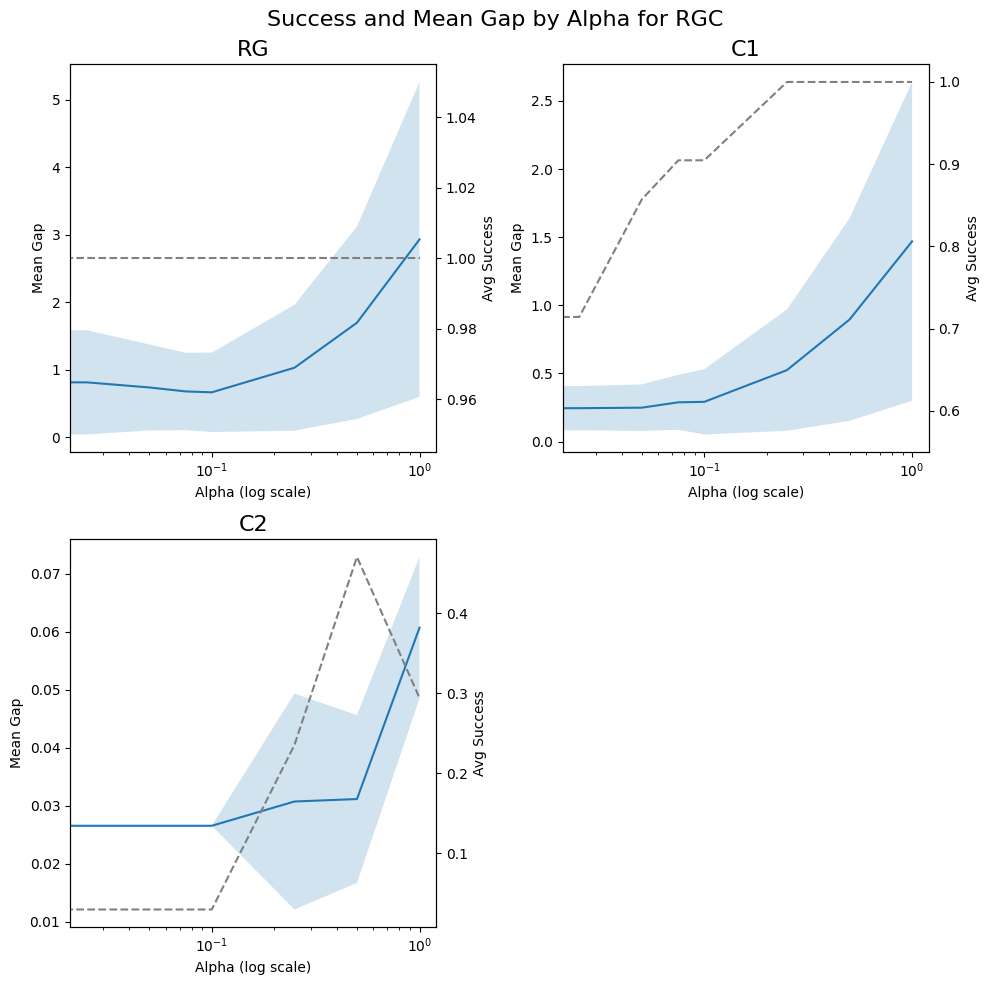

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

results = get_results()

results["success"] = results["cost_min"] != float('inf')
results.replace([np.inf, -np.inf], np.nan, inplace=True)

# Alpha plot for randomized_greedy
rg = results[results["method"] == "randomized_greedy"]

# Compute avg gap and std per dataset, subdataset, and alpha value, ignoring NaNs
rg_avg_gap = rg.groupby(['dataset', 'alpha'])['gap'].agg(['mean', lambda x: np.std(x.dropna())]).reset_index()
rg_avg_gap.rename(columns={'<lambda_0>': 'std'}, inplace=True)

# Compute avg gap and std per dataset and alpha value, ignoring NaNs
rg_dataset_avg_gap = rg.groupby(['dataset', 'alpha']).agg(
    avg_gap=('gap', 'mean'),
    std_gap=('gap', lambda x: np.std(x.dropna())),
    avg_success=('success', 'mean')
).reset_index()
display(rg_dataset_avg_gap)

# print total avg gap for each alpha

# Separate plots for generic and release datasets
datasets = rg['dataset'].unique()

# clear old plots
plt.close('all')

fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=False)
axes = axes.flatten()
axes[-1].set_visible(False)  # Leave one square empty

fig.suptitle("Success and Mean Gap by Alpha for RGC", fontsize=16)
fig.set_tight_layout(True)
for ax, dataset in zip(axes, datasets):
    dataset_data = rg_avg_gap[rg_avg_gap['dataset'] == dataset]
    dataset_success_data = rg_dataset_avg_gap[rg_dataset_avg_gap['dataset'] == dataset]
    
    ax2 = ax.twinx()  # Create a secondary y-axis

    # Plot mean gap
    sns.lineplot(x="alpha", y="mean", data=dataset_data, hue=None, ax=ax)
    ax.fill_between(dataset_data['alpha'], 
                    dataset_data['mean'] - dataset_data['std'], 
                    dataset_data['mean'] + dataset_data['std'], 
                    alpha=0.2)
    
    # Plot avg_success on the secondary y-axis
    sns.lineplot(x="alpha", y="avg_success", data=dataset_success_data, ax=ax2, color='gray', linestyle='--')
    
    ax.set_xscale('log')  # Set x-axis to logarithmic scale
    ax.set_title(f"{rename_dataset.get(dataset)}", fontsize=16)
    ax.set_xlabel("Alpha (log scale)")
    ax.set_ylabel("Mean Gap")
    ax2.set_ylabel("Avg Success")


plt.tight_layout()
import os
os.makedirs('../report/figures', exist_ok=True)
plt.savefig('../report/figures/alpha_vs_mean_gap_randomized_greedy.png')
plt.show()


### Alpha plot for mip construction alpha and beta plot for mip construction beta


Dataset construction_heuristics.csv already exists
Dataset construction_heuristics_agg.csv already exists


,dataset,alpha,mean,std
0,instances_generic,0.0,0.817338,0.826773
1,instances_generic,0.1,0.709392,0.756033
2,instances_generic,1.0,0.705891,0.768629
3,instances_generic,10.0,0.689355,0.753246
4,instances_release_1,0.0,0.055445,0.040710
5,instances_release_1,0.1,0.043420,0.031716
6,instances_release_1,1.0,0.072520,0.038918
7,instances_release_1,10.0,0.591404,0.366656
8,instances_release_2,0.0,0.132296,0.049646
9,instances_release_2,0.1,0.066070,0.021758


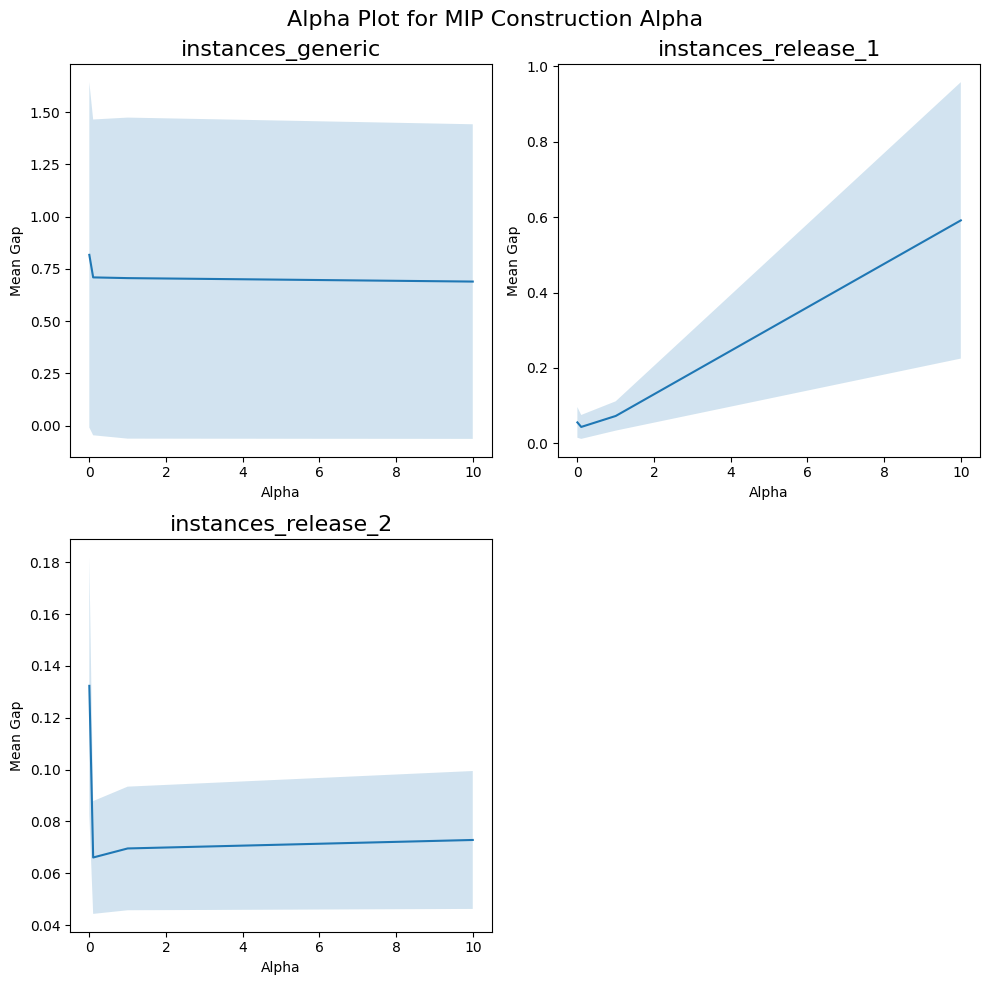

,dataset,beta,mean,std
0,instances_generic,1.1,0.691100,0.727564
1,instances_generic,1.5,0.706629,0.759878
2,instances_generic,2.0,0.702675,0.763148
3,instances_generic,5.0,0.699423,0.745868
4,instances_release_1,1.1,0.048737,0.042089
5,instances_release_1,1.5,0.048120,0.036477
6,instances_release_1,2.0,0.043406,0.032247
7,instances_release_1,5.0,0.043598,0.039101
8,instances_release_2,1.1,0.066384,0.026783
9,instances_release_2,1.5,0.064449,0.018782


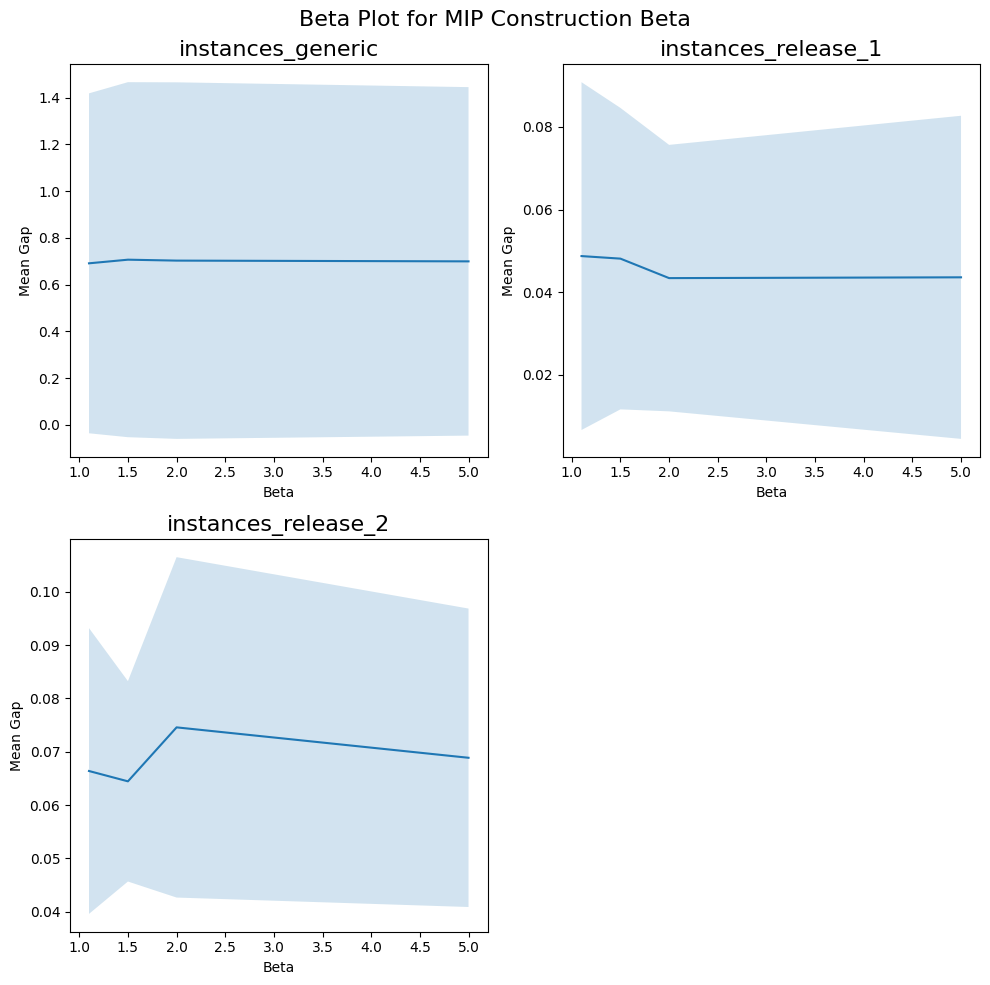

In [6]:
# mip construction alpha and beta plot for mip construction beta

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

results = get_results()

results["success"] = results["gap"] != float('inf')
results.replace([np.inf, -np.inf], np.nan, inplace=True)

def plot_alpha_beta(mip_avg_gap: np.ndarray, param: str, title: str) -> None:
    """
    Plots the mean gap against the given parameter (alpha or beta) for each dataset.

    :param mip_avg_gap: The aggregated gap data.
    :param param: The parameter to plot against ('alpha' or 'beta').
    :param title: The title for the plot.
    """
    unique_datasets = mip_avg_gap['dataset'].unique()
    num_datasets = len(unique_datasets)
    
    if num_datasets == 0:
        print(f"No datasets available for {title}.")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=False)
    axes = axes.flatten()
    for ax in axes[num_datasets:]:
        ax.set_visible(False)  # Hide unused subplots

    fig.suptitle(title, fontsize=16)
    fig.set_tight_layout(True)
    
    for ax, dataset in zip(axes, unique_datasets):
        dataset_data = mip_avg_gap[mip_avg_gap['dataset'] == dataset]

        # Plot mean gap
        sns.lineplot(x=param, y="mean", data=dataset_data, ax=ax)
        
        ax.fill_between(dataset_data[param], 
                        dataset_data['mean'] - dataset_data['std'], 
                        dataset_data['mean'] + dataset_data['std'], 
                        alpha=0.2)
        
        ax.set_title(f"{dataset}", fontsize=16)
        ax.set_xlabel(param.capitalize())
        ax.set_ylabel("Mean Gap")
    
    display(mip_avg_gap)
    
    plt.tight_layout()
    plt.show()

# Alpha plot for mip construction alpha
mip_alpha = results[results["method"] == "mip_randomized_construction_random_alpha"]
mip_alpha_avg_gap = mip_alpha.groupby(['dataset', 'alpha']).agg(
    mean=('gap', 'mean'),
    std=('gap', lambda x: np.std(x.dropna()))
).reset_index()
plot_alpha_beta(mip_alpha_avg_gap, 'alpha', 'Alpha Plot for MIP Construction Alpha')

# Beta plot for mip construction beta
mip_beta = results[results["method"] == "mip_randomized_construction_random_beta"]
mip_beta_avg_gap = mip_beta.groupby(['dataset', 'beta']).agg(
    mean=('gap', 'mean'),
    std=('gap', lambda x: np.std(x.dropna()))
).reset_index()
plot_alpha_beta(mip_beta_avg_gap, 'beta', 'Beta Plot for MIP Construction Beta')

### Alpha-beta plot for mip construction bias

Dataset construction_heuristics.csv already exists
Dataset construction_heuristics_agg.csv already exists


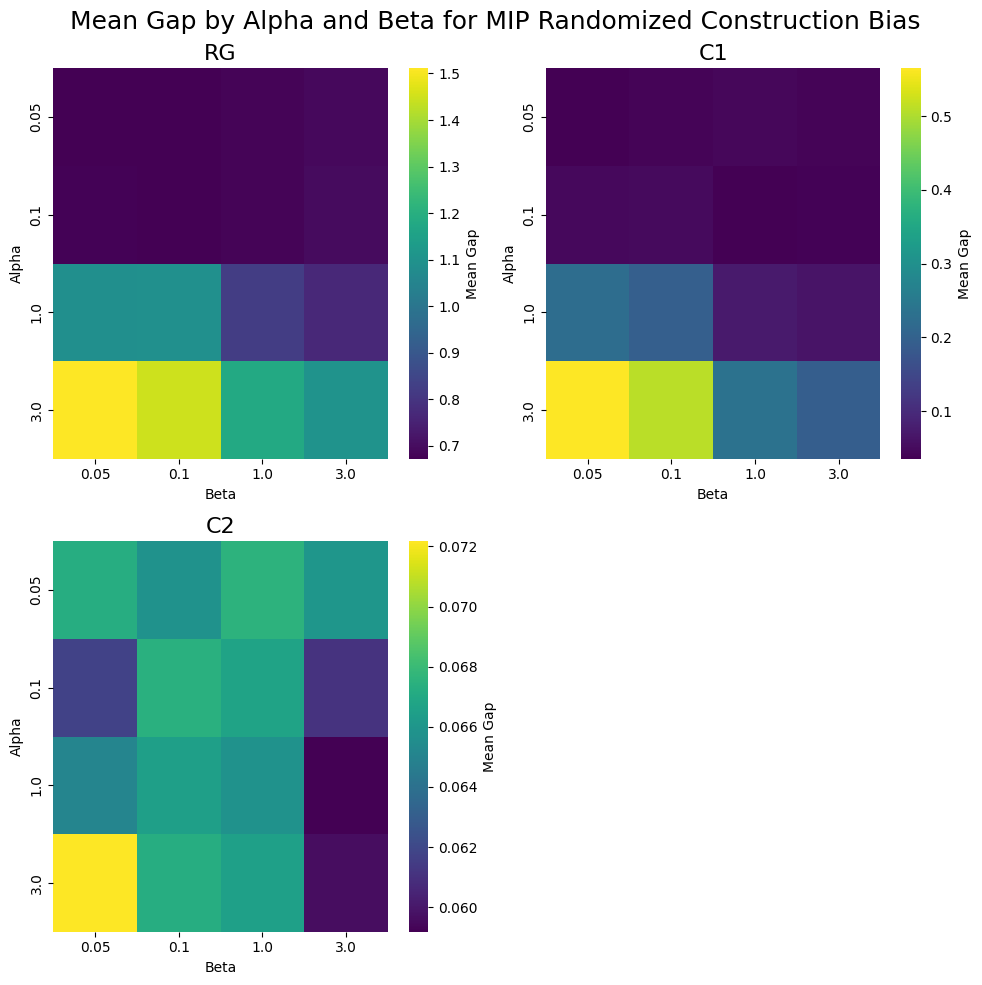

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

results = get_results()

# Ensure success column is correctly set
results["success"] = results["gap"] != float('inf')
results.replace([np.inf, -np.inf], np.nan, inplace=True)

# Filter results for the specific method
filtered_results = results[results["method"] == "mip_randomized_construction_bias"]

# Group by dataset, subdataset, alpha, and beta to calculate mean gap
bias_avg_gap = filtered_results.groupby(['dataset', 'subdataset', 'alpha', 'beta'])['gap'].mean().reset_index()

def plot_alpha_beta_grid(bias_avg_gap: pd.DataFrame) -> None:
    """

    :param bias_avg_gap: The aggregated gap data with alpha and beta.
    """
    unique_datasets = bias_avg_gap['dataset'].unique()
    num_datasets = len(unique_datasets)
    
    if num_datasets == 0:
        print("No datasets available for plotting.")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=False)
    axes = axes.flatten()
    axes[-1].set_visible(False)  # Leave one square empty
    if num_datasets == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one plot
    
    for ax, dataset in zip(axes, unique_datasets):
        dataset_data = bias_avg_gap[bias_avg_gap['dataset'] == dataset]
        # Use pivot_table with aggregation to handle duplicates
        pivot_table = dataset_data.pivot_table(index="alpha", columns="beta", values="gap", aggfunc='mean')
        # Sort the pivot table by alpha to ensure natural increasing order
        pivot_table.sort_index(ascending=True, inplace=True)
        sns.heatmap(pivot_table, ax=ax, cmap="viridis", cbar_kws={'label': 'Mean Gap'})
        ax.set_title(f"{rename_dataset.get(dataset)}", fontsize=16)
        ax.set_xlabel("Beta")
        ax.set_ylabel("Alpha")
    
    plt.suptitle("Mean Gap by Alpha and Beta for MIP Randomized Construction Bias", fontsize=18)
    plt.tight_layout()

    import os
    os.makedirs('../report/figures', exist_ok=True)
    plt.savefig('../report/figures/alpha_beta_grid_mip_randomized_construction_bias.png')

    plt.show()

# Plot the alpha-beta grid
plot_alpha_beta_grid(bias_avg_gap)


### Now we want to choose the best setting for each method, one choice per dataset

In [10]:

alpha_randomized_greedy: float = 0.1
alpha_mip_randomized_construction_bias: float = 0.1
beta_mip_randomized_construction_bias: float = 3.0

alpha_mip_randomized_construction_random_alpha: float = 0.1
beta_mip_randomized_construction_random_beta: float = 1.5

def filter_results_by_method(results: pd.DataFrame) -> pd.DataFrame:
    """
    Filters the results DataFrame based on specific method criteria.

    :param results: The DataFrame containing the results to filter.
    :return: A filtered DataFrame.
    """
    def apply_filter(row: pd.Series) -> bool:
        if row["method"] == "randomized_greedy":
            return row["alpha"] == alpha_randomized_greedy
        if row["method"] == "mip_randomized_construction_bias":
            return (row["alpha"] == alpha_mip_randomized_construction_bias) and (row["beta"] == beta_mip_randomized_construction_bias)
        if row["method"] == "mip_randomized_construction_random_alpha":
            return row["alpha"] == alpha_mip_randomized_construction_random_alpha
        if row["method"] == "mip_randomized_construction_random_beta":
            return row["beta"] == beta_mip_randomized_construction_random_beta
        return True

    return results[results.apply(apply_filter, axis=1)]

results = get_results()
print(results.method.unique())

before = len(results)
results = filter_results_by_method(results)

after = len(results)
print(f"Filtered {before - after} rows")

# Ensure success column is correctly set
results["success"] = results["cost_min"] != float('inf')
results.replace([np.inf, -np.inf], np.nan, inplace=True)

# Correct the groupby to use a list for multiple columns
aggregated_results = results.groupby(['dataset', 'method']).agg(
    mean_gap=('gap', 'mean'),
    std_gap=('gap', lambda x: np.std(x.dropna())),
    success_rate=('success', 'mean'),
    mean_runtime=('wall_time_sum', 'mean'),
    std_runtime=('wall_time_sum', lambda x: np.std(x.dropna()))
).reset_index()

rename_dataset = {
    "instances_generic": "RG",
    "instances_release_1": "C1",
    "instances_release_2": "C2"
}

aggregated_results["dataset"] = aggregated_results["dataset"].map(rename_dataset)

# Reshape the DataFrame to have multirows, one row per method and dataset
aggregated_results = aggregated_results.melt(
    id_vars=['method', 'dataset'],
    value_vars=['mean_gap', 'std_gap', 'success_rate', 'mean_runtime', 'std_runtime'],
    var_name='metric',
    value_name='value'
)

# Pivot the DataFrame to have 'method' and 'dataset' as multirows, and 'metric' as columns
aggregated_results = aggregated_results.pivot_table(
    index=['method', 'dataset'],
    columns='metric',
    values='value'
)

# display the table
display(aggregated_results)
print(aggregated_results.to_latex(
    multirow=True))


Dataset construction_heuristics.csv already exists
Dataset construction_heuristics_agg.csv already exists
['gurobi' 'mip_randomized_construction_bias'
 'mip_randomized_construction_random_alpha'
 'mip_randomized_construction_random_beta' 'randomized_greedy'
 'simple_randomized']
Filtered 6580 rows


metric                                            mean_gap  mean_runtime  \
method                                   dataset                           
gurobi                                   RG       0.850512     26.948429   
mip_randomized_construction_bias         C1       0.037652      4.068594   
                                         C2       0.061099      1.890665   
                                         RG       0.696526      1.077393   
mip_randomized_construction_random_alpha C1       0.043420      3.192148   
                                         C2       0.066070      6.086119   
                                         RG       0.709392      1.134554   
mip_randomized_construction_random_beta  C1       0.048120      3.174252   
                                         C2       0.064449      5.894710   
                                         RG       0.706629      1.132318   
randomized_greedy                        C1       0.291722      0.052254   
                                         C2       0.026533      1.478919   
                                         RG       0.668064      0.000823   
simple_randomized                        C1       1.636293      0.000672   
                                         C2            NaN      0.000291   
                                         RG       2.963843      0.000221   

metric                                             std_gap  std_runtime  \
method                                   dataset                          
gurobi                                   RG       1.919726    27.417750   
mip_randomized_construction_bias         C1       0.027356     5.061884   
                                         C2       0.018204     1.448277   
                                         RG       0.749084     1.787862   
mip_randomized_construction_random_alpha C1       0.031716     3.630342   
                                         C2       0.021758     3.758644   
                                         RG       0.756033     1.906390   
mip_randomized_construction_random_beta  C1       0.036477     3.306737   
                                         C2       0.018782     3.653458   
                                         RG       0.759878     1.883238   
randomized_greedy                        C1       0.239616     0.103797   
                                         C2       0.000000     1.632984   
                                         RG       0.588448     0.000447   
simple_randomized                        C1       1.252310     0.000427   
                                         C2            NaN     0.000159   
                                         RG       2.353854     0.000163   

metric                                            success_rate  
method                                   dataset                
gurobi                                   RG           1.000000  
mip_randomized_construction_bias         C1           1.000000  
                                         C2           1.000000  
                                         RG           1.000000  
mip_randomized_construction_random_alpha C1           1.000000  
                                         C2           1.000000  
                                         RG           1.000000  
mip_randomized_construction_random_beta  C1           1.000000  
                                         C2           1.000000  
                                         RG           1.000000  
randomized_greedy                        C1           0.904762  
                                         C2           0.029412  
                                         RG           1.000000  
simple_randomized                        C1           0.952381  
                                         C2           0.000000  
                                         RG           1.000000

\begin{tabular}{llrrrrr}
\toprule
 & metric & mean_gap & mean_runtime & std_gap & std_runtime & success_rate \\
method & dataset &  &  &  &  &  \\
\midrule
gurobi & RG & 0.850512 & 26.948429 & 1.919726 & 27.417750 & 1.000000 \\
\cline{1-7}
\multirow[t]{3}{*}{mip_randomized_construction_bias} & C1 & 0.037652 & 4.068594 & 0.027356 & 5.061884 & 1.000000 \\
 & C2 & 0.061099 & 1.890665 & 0.018204 & 1.448277 & 1.000000 \\
 & RG & 0.696526 & 1.077393 & 0.749084 & 1.787862 & 1.000000 \\
\cline{1-7}
\multirow[t]{3}{*}{mip_randomized_construction_random_alpha} & C1 & 0.043420 & 3.192148 & 0.031716 & 3.630342 & 1.000000 \\
 & C2 & 0.066070 & 6.086119 & 0.021758 & 3.758644 & 1.000000 \\
 & RG & 0.709392 & 1.134554 & 0.756033 & 1.906390 & 1.000000 \\
\cline{1-7}
\multirow[t]{3}{*}{mip_randomized_construction_random_beta} & C1 & 0.048120 & 3.174252 & 0.036477 & 3.306737 & 1.000000 \\
 & C2 & 0.064449 & 5.894710 & 0.018782 & 3.653458 & 1.000000 \\
 & RG & 0.706629 & 1.132318 & 0.759878 & 1.883238 & 1